In [35]:
# append parent to path to allow imports
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [36]:
from pathlib import Path
import cv2
import numpy as np

from src.face import FaceDetector
from src.mask import MaskHandler
from src.utils.project_utils import Utils
from src.region import Region, Phi_N, SuperpixelProbability
from src.superpixels import SuperpixelExtractor
from src.feature import Feature, FeatureExtractor, FeatureDivergence, EFeature

In [37]:
fd = FaceDetector("../assets/lbfmodel.yaml")
mh = MaskHandler()

IMAGE_PATH = Path("test_images/hehe.jpg")

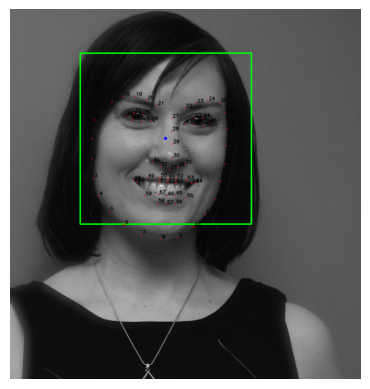

In [38]:
img_rgb, _, _, landmarks_all_faces = fd.detect(IMAGE_PATH, display_indices=True)
Utils.display(img_rgb)

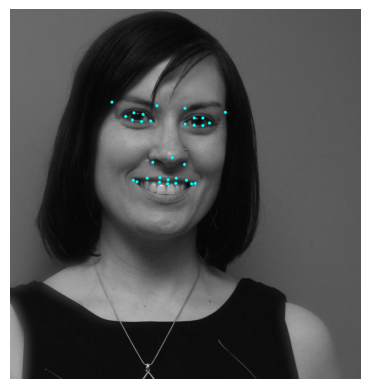

1


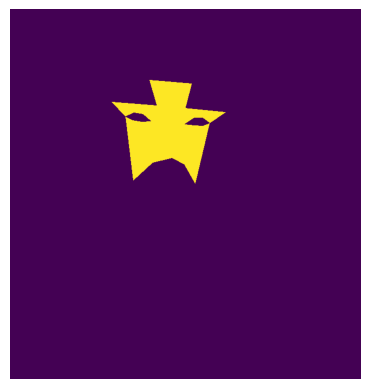

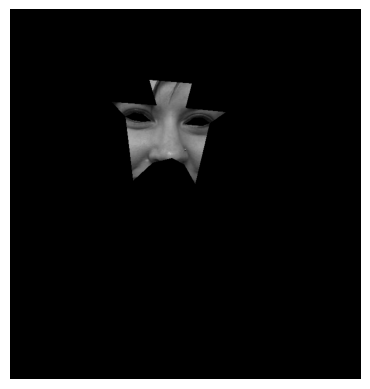

In [39]:
masked_img, selected_pts = mh.get_mask_points(IMAGE_PATH, landmarks_all_faces)
Utils.display(masked_img)

masks, masked_imgs = mh.build_masks(IMAGE_PATH, selected_pts, landmarks_all_faces)
print(len(masks))
Utils.display(masks[0])
Utils.display(masked_imgs[0])

1


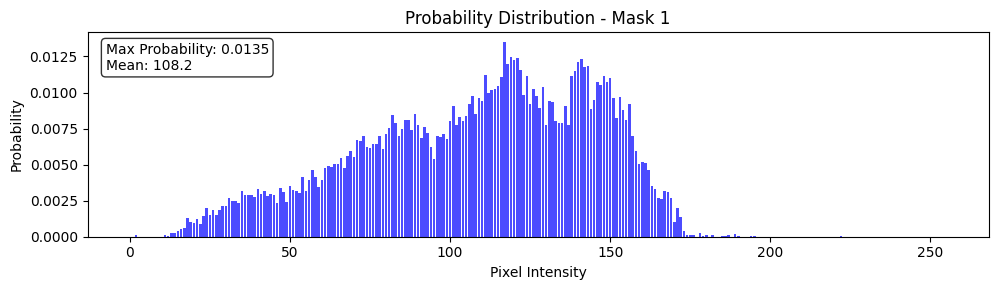

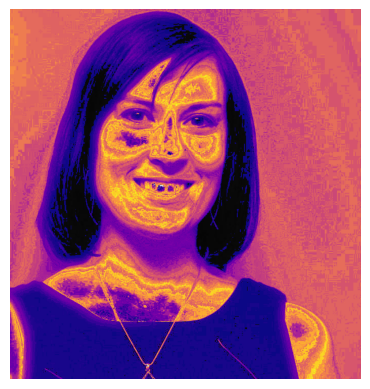

In [40]:
intensity_histograms = mh.get_intensity_histograms(IMAGE_PATH, masks)

print(len(intensity_histograms))
Utils.visualize_histograms(intensity_histograms)
Utils.apply_intensity_probability_map(IMAGE_PATH, intensity_histograms[0])

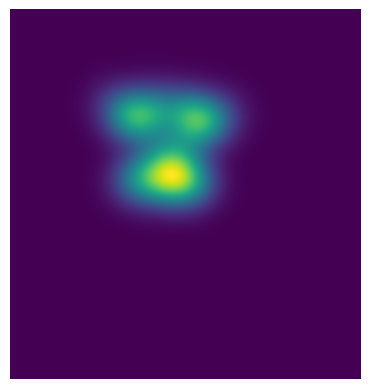

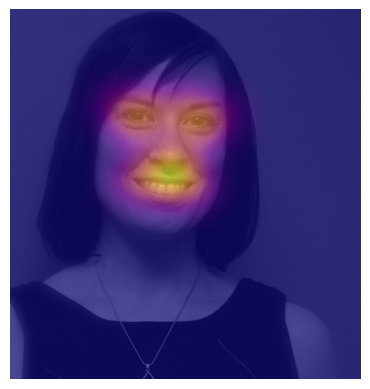

In [41]:
prior_face_masks, heatmaps, heatmaps_blended = mh.get_prior_face_masks(
    IMAGE_PATH, selected_pts
)

idx = 0
Utils.display(prior_face_masks[idx])
Utils.display(heatmaps_blended[idx])

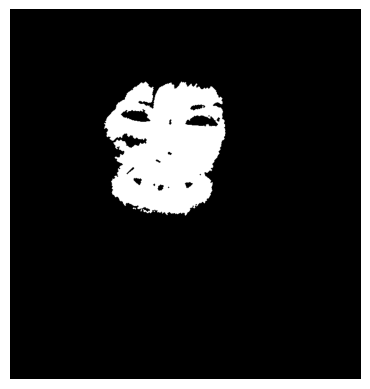

255 0


In [42]:
alpha = 0.9
lambda_ = 0.0018
skin_pixel_maps = mh.get_skin_pixel_maps(
    IMAGE_PATH,
    intensity_histograms,
    prior_face_masks,
    alpha,
    lambda_,
    selected_pts,
    True,
)

skin_pixel_maps = [Utils.morphological_cleanup(s) for s in skin_pixel_maps]

idx = 0
Utils.display(skin_pixel_maps[idx], cmap="gray")
print(skin_pixel_maps[idx].max(), skin_pixel_maps[idx].min())

In [43]:
spe = SuperpixelExtractor(region_size=20)
slic, contoured_img, labels, num_superpixels = spe.get_slic_superpixels(IMAGE_PATH)
num_superpixels

1224

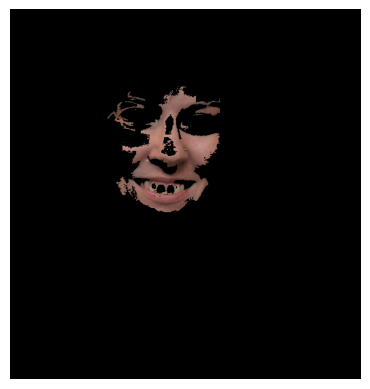

In [44]:
mask_labels = spe.get_mask_labels(slic, skin_pixel_maps[0], 1)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), mask_labels)

In [45]:
fe = FeatureExtractor()
feature_vectors = fe.extract_all_features_superpixels(IMAGE_PATH, slic)

In [46]:
r = Region(
    [
        EFeature.MEAN_INTENSITY,
        EFeature.STD_INTENSITY,
        EFeature.ENTROPY,
        EFeature.LACUNARITY_VECTOR,
    ],
    kappa=np.float64(0.5)
)

mask_fv, non_mask_fv = r.separate_feature_vectors(feature_vectors, mask_labels)

In [47]:
most_favorable_divergences = [r.get_most_favorable_divergence(mask_fv, fv) for fv in non_mask_fv]

[43, 76, 453, 495, 695, 696, 729, 824, 860, 889, 893, 1021]


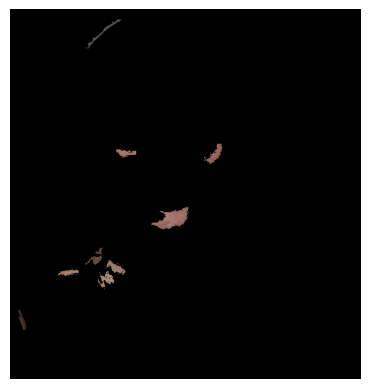

In [49]:
seeds = r.select_seed_superpixel_labels(most_favorable_divergences, 0.99)
print(seeds)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), seeds)